In this tutorial, we will learn to implement simple GCN and GraphSage model by [PyG (PyTorch Geometric) library](https://pytorch-geometric.readthedocs.io/en/latest/index.html) . We will work on the node classification and link prediction tasks on a real dataset: Cora.

# Install Packages
Before we move on to the modeling part, we need to ensure the pytorch version so that it's compatible with the PyG library. There are several supported pytorch version (and CUDA version). For illustration, we use 'pytorch == 2.2.2+cu118' as the supported version in this tutorial. We also use pip installer as the version controling tool. So the first step for you is to check whether you have the right version.

In [1]:
!pip list -v | grep torch

torch                            2.2.2+cu118           /usr/local/lib/python3.10/dist-packages pip
torchaudio                       2.2.2+cu118           /usr/local/lib/python3.10/dist-packages pip
torchdata                        0.7.1                 /usr/local/lib/python3.10/dist-packages pip
torchsummary                     1.5.1                 /usr/local/lib/python3.10/dist-packages pip
torchtext                        0.17.1                /usr/local/lib/python3.10/dist-packages pip
torchvision                      0.17.2+cu118          /usr/local/lib/python3.10/dist-packages pip


From the first line of the text above, we can check if the version of pytorch is indeed 2.2.2+cu118. If the version is correct, please skip this part. If not, please update the pytorch version by running the following code. CRITICAL: the code will uninstall your original pytorch version and install the newest one.  
ATTENTION!!! Everytime the output ask you "Proceed (y/n)?", please input "y" in the box.

In [7]:
!pip uninstall torch torchvision torchaudio
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Found existing installation: torch 2.2.2
Uninstalling torch-2.2.2:
  Would remove:
    /usr/local/bin/convert-caffe2-to-onnx
    /usr/local/bin/convert-onnx-to-caffe2
    /usr/local/bin/torchrun
    /usr/local/lib/python3.10/dist-packages/functorch/*
    /usr/local/lib/python3.10/dist-packages/torch-2.2.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/torch/*
    /usr/local/lib/python3.10/dist-packages/torchgen/*
Proceed (Y/n)? Y
  Successfully uninstalled torch-2.2.2
Found existing installation: torchvision 0.17.2
Uninstalling torchvision-0.17.2:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/torchvision-0.17.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/torchvision.libs/libcudart.7ec1eba6.so.12
    /usr/local/lib/python3.10/dist-packages/torchvision.libs/libjpeg.ceea7512.so.62
    /usr/local/lib/python3.10/dist-packages/torchvision.libs/libnvjpeg.f00ca762.so.12
    /usr/local/lib/python3.10/dist-packages/torchvision.libs/libpng16.7f72a3c5.so.16
    /

Then, we install the PyG library by running the following code.

In [2]:
!pip install torch_geometric

  Using cached torch_geometric-2.5.2-py3-none-any.whl (1.1 MB)


Finally, let's import them and see if everything runs smoothly.

In [3]:
import torch
import torch_geometric
torch.manual_seed(596)

# Data Inspection
The data is [Cora](https://relational.fit.cvut.cz/dataset/CORA), one of the benchmark datasets for graph learning. The dataset is already embedded in the PyG library. We can download and process it by directly running the following. Note that the PyG library has many [embeded dataset](https://pytorch-geometric.readthedocs.io/en/latest/notes/data_cheatsheet.html). You can always load the others using the similar coding.

In [4]:
planetoid = torch_geometric.datasets.Planetoid(root='/tmp/Cora', name='Cora')
data = planetoid[0]

Processing...
Done!


Here, we define 'planetoid' as the collector of data, and 'data' as data we use for modeling. The 'planetoid' stores meta attributes such as number of features and number of label classes. The 'data' object on the other hand stores and specific data itself, as the following.

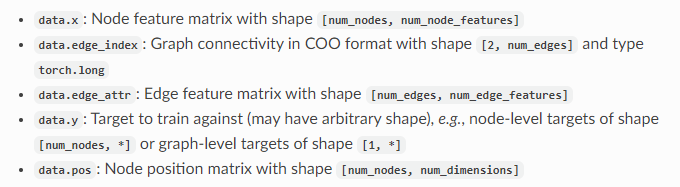

In [5]:
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [6]:
data.y

tensor([3, 4, 4,  ..., 3, 3, 3])

# GCN
In this section, we implement a GCN model for node classification and link prediction problem.

## Node Classification
Let's define a two-layer GCN for the node classification task. Note that the GCN layer used here is not the original vanilla GCN layer. It's an evolved version where the message passing mechanism is more advanced. Nevertheless, they are very similar from a high-level understanding. Please find the details regarding this GCN layer in the following paper [Semi-Supervised Classification with Graph Convolutional Networks](https://arxiv.org/abs/1609.02907).

For the first layer, the input dimension will be the same as the feature dimension of the node features; the output dimension will be the dimension for the hidden representation, which is specified as 16 here. The output is further processed by a ReLU activation function.

For the second layer, the input dimension is 16, same as the dimension of the hidden representation; The output dimension is the number of label classes. The output is further processed by a log Softmax activation function so that the output is scaled into a probability score for each class label.

Note that the GCNConv() function has two input: input features and the edge index. The edge index will tell the model how the information (input features) communicate on the graph structure.

In [14]:
class GCN(torch.nn.Module):
    def __init__(self, dataset):
        super().__init__()
        self.conv1 = torch_geometric.nn.GCNConv(dataset.num_node_features, 16)
        self.conv2 = torch_geometric.nn.GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.nn.functional.log_softmax(x, dim=1)
        return x

Next, we train our model based on the training data. First let's set up some training environment. We use Adam as the optimizer here. The learning rate is 0.01, and we also specify the L2 penalty with weight 5e-4.

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
model = GCN(planetoid).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

We train the model with 200 epochs. The gradient is calculated with respect to the [negative log likelihood loss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html) function. Note that we only use the labels in the training mask to train the model.

In [9]:
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = torch.nn.functional.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

Next, we evaluate the model on the testing side.

In [10]:
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8090


## Link Prediction





For the link prediction task, things are a little bit more complicated. Because when we are dealing with node classification task, we would assume we can observe the information of node labels and train on them. Therefore the model is learned in a supervised fashion. However, in the link prediction task, we usually don't assume that we can observe the node labels (even if we do, we will call the node labels as external information). Therefore the model is learned in a self-supervised fashion in the link prediction task ---- all the information is from the graph structure itself and node features.

More specifically, if we want to map the link prediction task into a classification task, we will have to learn the model based on edges. In other words, the respones variable is a binary variable for each potential edge where 1 means the edge exists in graph and 0 means it doesn't. Since every pair of nodes form a potential edge, we will have N x N combinations and therefore N x N number of response variable.

We certainlly can directly learn on those N x N number of response variables as a classification task. However, it's pratically infeasible because:

1.   The binary response variable is imbalance. (Too many 0 when graph is sparse).
2.   Too many response variable. When the graph is large, there are too many potential edges to enumerate.

To tackle those issue, we usually introduce negative sampling technique (similar to [word2vec](https://stackoverflow.com/questions/27860652/word2vec-negative-sampling-in-layman-term) and other NLP models) for link prediction. In a word, for each existing edge in the graph (positive sample), we sample a non-existing counterpart (negative sample) to contrast with. For each epoch, the negative sample is created by randomly replacing a node in each positive sample. The classification loss function (BCELoss in our case) will be computed where the positive samples have response 1 and the negative samples have response 0. Then, the model is tuned wrt. the loss function.

Note that we avoid enumerating all possible edges by this technique. Theory also has been proved that the negative sampling technique eventually works the same as enumerating all possible edges and do classification.

For the model architecture, the graph layers are composed of two GCN layer with ReLU activision. After the second layer, the hidden representation on the nodes have dimension 12. The edges representation are the concatenation of the two nodes, therefore they have the dimension 24. Further, the edges representation will passed on two linear layer with ReLU for the first layer and sigmoid activision for the seond.

The forward function of the GCN class return two outputs: the first one is the predicted probability of positive edges and the second one is the predicted probability of negative edges. Note that for each epoch, the negative edges are newly generated.

In [15]:
class GCN(torch.nn.Module):
    def __init__(self, dataset):
        super().__init__()
        self.conv1 = torch_geometric.nn.GCNConv(dataset.num_node_features, 16)
        self.conv2 = torch_geometric.nn.GCNConv(16, 12)
        self.linear1 = torch.nn.Linear(24, 24)
        self.linear2 = torch.nn.Linear(24, 1)

    def forward(self, x, train_edge_index, pred_edge_index):
        x = self.conv1(x, train_edge_index)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x, train_edge_index)
        x = torch.nn.functional.relu(x)

        x_positive = torch.cat((x[pred_edge_index[0,:],:],
                                x[pred_edge_index[1,:],:]), dim=1)
        x_positive = self.linear1(x_positive)
        x_positive = torch.nn.functional.relu(x_positive)
        x_positive = self.linear2(x_positive)
        x_positive = torch.sigmoid(x_positive)

        x_negative = torch.cat((x[torch.randint(high = x.shape[0], size = (pred_edge_index.shape[1],)),:],
                                x[pred_edge_index[1,:],:]), dim=1)
        x_negative = self.linear1(x_negative)
        x_negative = torch.nn.functional.relu(x_negative)
        x_negative = self.linear2(x_negative)
        x_negative = torch.sigmoid(x_negative)
        return x_positive.squeeze(), x_negative.squeeze()

Note that the forward function in the GCN() class have three inputs:
1.   x: the node features.
2.   train_edge_index: the edges we can observe for message passing.
3.   pred_edge_index: the edges we want to predict on.

For training stage, we specify 'train_edge_index' the same as 'pred_edge_index', because the edges for message passing and prediction are the same. For testing stage, the 'train_edge_index' will be the observed edges, and the 'pred_edge_index' will be the unobserved edges we want to evaluate the model on. Therefore those two arguments will be different.

After defining the architecture, we split all the edges with 0.8 training ratio. In other word, we only assume we can observe 80% of all the edges for training (message passing and fitting). We employ [BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html) as the loss function.

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
train_size = round(0.8*data.edge_index.shape[1])
model = GCN(planetoid).to(device)
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

The model is trained with 200 epochs. For each epoch, the target is the vector $y$:

\begin{align}
    y = [1,\dots,1,0,\dots,0]^T \notag
\end{align}

The target vector $y$ has length two times the training size, where the first half (ones) is the response variable for positive edges and the second half (zeros) is the response variable for negative edges.

In [17]:
for epoch in range(200):
    optimizer.zero_grad()
    target = torch.concat((torch.ones((train_size,), device = device), torch.zeros((train_size,), device = device)))

    out = model(data.x,
                data.edge_index[:, :train_size],
                data.edge_index[:, :train_size])
    pred = torch.concat(out)
    loss = loss_fn(pred, target)
    loss.backward()
    optimizer.step()

After training, we evaluate the model on the test side. We use [recall](https://en.wikipedia.org/wiki/Precision_and_recall) as the evaluation metric.

In [18]:
pred = model(data.x,
             data.edge_index[:, :train_size],
             data.edge_index[:, train_size:])[0]
correct = (pred >= 0.5).sum()
recall = int(correct) / (data.edge_index.shape[1] - train_size)
print(f'Recall: {recall:.4f}')

Recall: 0.8333


# GraphSage

Similarly, we implement the GraphSage model. The setting and tasks are the same as in the GCN case.

## Node Classification

Here, the only difference comparing to the node classification in GCN case is the graph learning layer: we change from GCN to GraphSage.

In [ ]:
class GraphSage(torch.nn.Module):
    def __init__(self, dataset):
        super().__init__()
        self.conv1 = torch_geometric.nn.SAGEConv(dataset.num_node_features, 16)
        self.conv2 = torch_geometric.nn.SAGEConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x, edge_index)
        x = torch.nn.functional.log_softmax(x, dim=1)
        return x

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
model = GraphSage(planetoid).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = torch.nn.functional.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.7950


## Link Prediction

Similarly, we employ GraphSage for link prediction.

In [ ]:
class GraphSage(torch.nn.Module):
    def __init__(self, dataset):
        super().__init__()
        self.conv1 = torch_geometric.nn.SAGEConv(dataset.num_node_features, 16)
        self.conv2 = torch_geometric.nn.SAGEConv(16, 12)
        self.linear1 = torch.nn.Linear(24, 24)
        self.linear2 = torch.nn.Linear(24, 1)

    def forward(self, x, train_edge_index, pred_edge_index):
        x = self.conv1(x, train_edge_index)
        x = torch.nn.functional.relu(x)
        x = self.conv2(x, train_edge_index)
        x = torch.nn.functional.relu(x)

        x_positive = torch.cat((x[pred_edge_index[0,:],:],
                                x[pred_edge_index[1,:],:]), dim=1)
        x_positive = self.linear1(x_positive)
        x_positive = torch.nn.functional.relu(x_positive)
        x_positive = self.linear2(x_positive)
        x_positive = torch.sigmoid(x_positive)

        x_negative = torch.cat((x[torch.randint(high = x.shape[0], size = (pred_edge_index.shape[1],)),:],
                                x[pred_edge_index[1,:],:]), dim=1)
        x_negative = self.linear1(x_negative)
        x_negative = torch.nn.functional.relu(x_negative)
        x_negative = self.linear2(x_negative)
        x_negative = torch.sigmoid(x_negative)
        return x_positive.squeeze(), x_negative.squeeze()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)
train_size = round(0.8*data.edge_index.shape[1])
model = GraphSage(planetoid).to(device)
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

for epoch in range(200):
    optimizer.zero_grad()
    target = torch.concat((torch.ones((train_size,), device = device), torch.zeros((train_size,), device = device)))

    out = model(data.x,
                data.edge_index[:, :train_size],
                data.edge_index[:, :train_size])
    pred = torch.concat(out)
    loss = loss_fn(pred, target)
    loss.backward()
    optimizer.step()

pred = model(data.x,
             data.edge_index[:, :train_size],
             data.edge_index[:, train_size:])[0]
correct = (pred >= 0.5).sum()
recall = int(correct) / (data.edge_index.shape[1] - train_size)
print(f'Recall: {recall:.4f}')

Recall: 0.5547
